<h1>BERTopic</h1>

En esta notebook usaremos [BERTopic](https://github.com/MaartenGr/BERTopic) para la tarea de Topic Modelling.

Este modelo usa un modelo de BERT para producir embeddings de documentos que luego son clusterizados y agrupados usando TF-IDF.

[Más información](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)

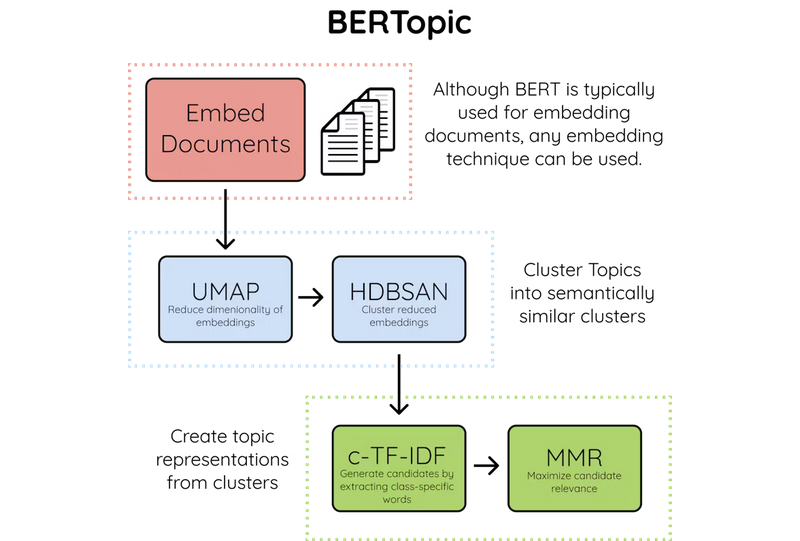

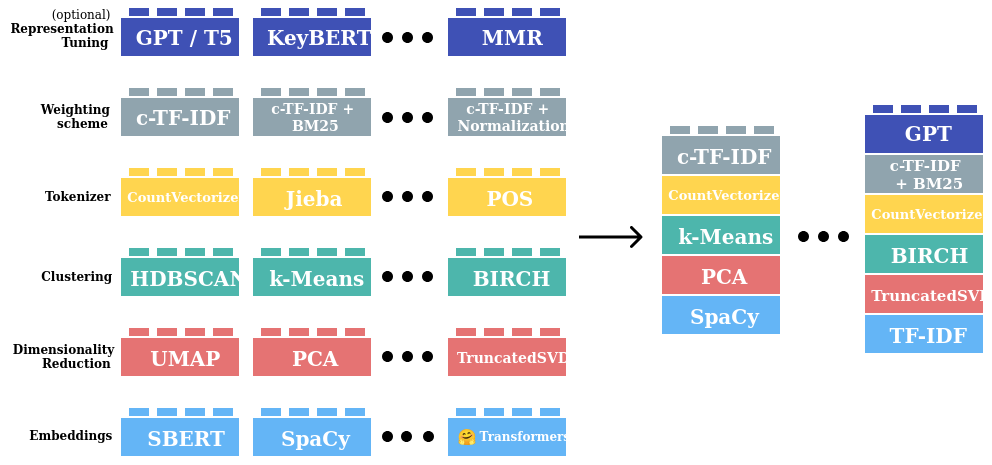

# 🔴 Tarea:

Obtener los embeddings de cada documento con algún modelo tipo BERT y clusterizarlos. ¿Se mejoran los rendimientos?

In [1]:
from transformers import AlbertTokenizerFast, AlbertModel
import nltk
from nltk import word_tokenize
import re
from string import punctuation
import torch

nltk.download('punkt') # este ya va de salida
nltk.download('punkt_tab')
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')


tokenizer = AlbertTokenizerFast.from_pretrained('albert/albert-base-v2')
model = AlbertModel.from_pretrained('albert/albert-base-v2')

2024-11-21 22:55:57.630357: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 22:55:57.826062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732254957.910718    2738 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732254957.933758    2738 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 22:55:58.115890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def get_bert_embeddings(texts, tokenizer, model, device='cpu'):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    embeddings = []
    with torch.no_grad():
        for text in texts:
            # Tokenize and pad input
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Get hidden states
            outputs = model(**inputs)
            # Pooling: Use mean of all token embeddings (or CLS token if preferred)
            token_embeddings = outputs.last_hidden_state
            sentence_embedding = torch.mean(token_embeddings, dim=1).squeeze().cpu().numpy()
            embeddings.append(sentence_embedding)
    
    return embeddings

In [3]:
from sklearn.datasets import fetch_20newsgroups

all_data = fetch_20newsgroups(subset='all',
                                remove=('headers', 'footers', 'quotes'),
                                categories=['sci.space', 'rec.sport.baseball','sci.med'],
                                random_state=642
                                )

X_raw = all_data.data
y = all_data.target

In [4]:
tokenized_docs = [[x for x in word_tokenize(doc) if x not in stopwords and x not in punctuation]
                        for doc in X_raw]
docs = [' '.join(doc) for doc in tokenized_docs]

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embeddings = get_bert_embeddings(docs, tokenizer, model, device)

In [6]:
from sklearn.cluster import KMeans, DBSCAN

# Cluster embeddings
n_clusters = 3  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [7]:
# Print results
for text, label in zip(X_raw[:1], labels):
    print(f"Text: {text} => Cluster: {label}")

Text: Reply address: mark.prado@permanet.org

If anyone knows anyone else who would like to get sci.space,
but doesn't have an Internet feed (or has a cryptic Internet
feed), I would be willing to feed it to them.  I have a nice
offline message reader/editor, an automated modem "mailer"
program which will pick up mail bundles (quickly and easily),
and an INSTALL.EXE to set them up painlessly.  No charge for
the sci.space feed, though you have to dial Washington, D.C.
This is NOT a BBS -- it's a store & forward system for mail
bundles, with minimum connect times.  (I'm used to overseas
calls.)  (This is not an offer for a free feed for any other
particular newsgroups.)  Speeds of up to 14400 (v32bis) are
supported.  VIP's might be offered other free services, such
as Internet address and other functionality.

I get my feed from UUNET and run a 4-line hub.  I've been
hubbing for years -- I have an extremely reliable hub.

The software I provide runs under MS-DOS (and OS/2 and Windows
as 

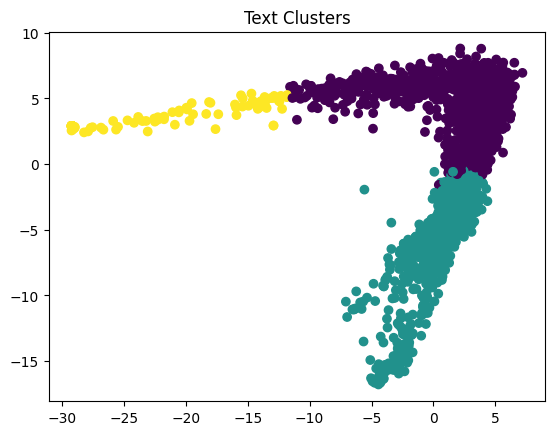

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
# for i, text in enumerate(X_train_raw):
#     plt.annotate(f"{i}", (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("Text Clusters")
plt.show()

In [9]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

print(f"AMI: {adjusted_mutual_info_score(y, labels)}")
print(f"ARI: {adjusted_rand_score(y, labels)}")

AMI: 0.009416621756670861
ARI: 0.00897451796941902


/tmp/ipykernel_2738/1615671369.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


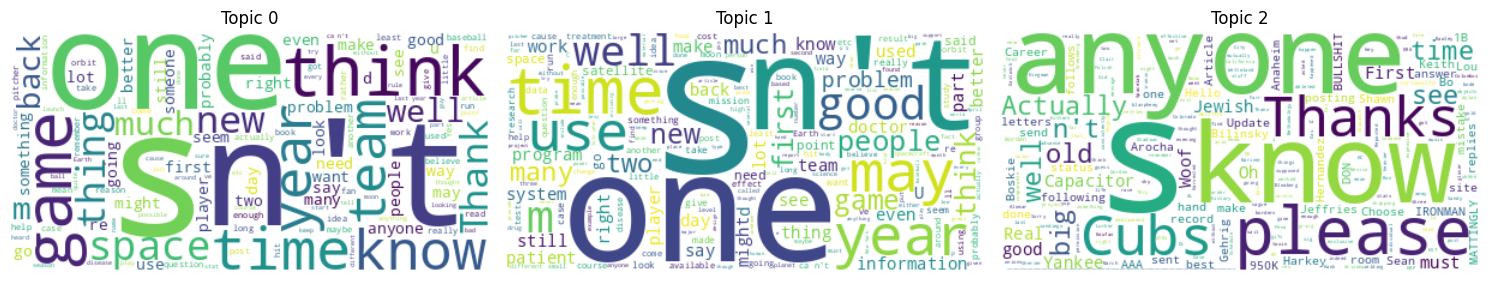

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

docs_idxs_per_topic = [np.where(np.array(labels) == i)[0] for i in range(n_clusters)]

fig, axs = plt.subplots(1, n_clusters, figsize=(15, 15))
for ax,j in zip(axs.flatten(),range(n_clusters)):
    topic_docs = " ".join([docs[i] for i in docs_idxs_per_topic[j]])
    wc = WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Topic {j}")
    ax.axis("off")
fig.tight_layout()
fig.show()